# **Machine Learning para Business Intelligence** 
#### Profesor: Daniel Aguirre

## 7. Minería de Texto

In [106]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
import re
from sklearn.metrics import accuracy_score, recall_score, precision_score
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

pd.set_option('display.max_columns',50)

## Transformación Matriz TFIDF

In [159]:
vectorizer = CountVectorizer()
corpus = ["El perro de Alejandra juega con la pelota de Daniel", "Daniel juega futbol", "Daniel tiene 80 años"]

tf = vectorizer.fit_transform(corpus)

pd.DataFrame(tf.toarray(),columns=vectorizer.get_feature_names_out())

,80,alejandra,años,con,daniel,de,el,futbol,juega,la,pelota,perro,tiene
0,0,1,0,1,1,2,1,0,1,1,1,1,0
1,0,0,0,0,1,0,0,1,1,0,0,0,0
2,1,0,1,0,1,0,0,0,0,0,0,0,1


In [173]:
vectorizer = TfidfVectorizer()
corpus = ["El perro de Alejandra juega con la pelota de Daniel", "Daniel juega futbol", "Daniel tiene 80 años"]

tf = vectorizer.fit_transform(corpus)

pd.DataFrame(tf.toarray(),columns=vectorizer.get_feature_names_out())

,80,alejandra,años,con,daniel,de,el,futbol,juega,la,pelota,perro,tiene
0,0.000000,0.302514,0.000000,0.302514,0.178669,0.605027,0.302514,0.000000,0.230069,0.302514,0.302514,0.302514,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.425441,0.000000,0.000000,0.720333,0.547832,0.000000,0.000000,0.000000,0.000000
2,0.546454,0.000000,0.546454,0.000000,0.322745,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.546454


### Análisis de sentimiento

In [12]:
reseñas = pd.read_csv('reviews.csv')
reseñas = reseñas.dropna(subset=['review','score'])

In [13]:
reseñas.head()

,id_review,review,title,score,likes,id_nick,service,date,platform
0,R1245,Muy buena presentación y servicio sin embargo ...,Muy buena presentación y servicio,3.0,0,uisahelenad2018,71036.0,1 years ago,tripadvisor
1,R1246,Desde la presentación de los platos a la calid...,Una experiencia,5.0,0,turrutia,71036.0,1 years ago,tripadvisor
2,R1247,El mejor lugar para reencontrame con mis amigo...,Felicitaciones a Statera!,5.0,0,orthStar25333985745,71036.0,1 years ago,tripadvisor
3,R1248,Excelente experiencia Comida maravillosa con e...,Aniversario de boda,5.0,0,atima J,71036.0,1 years ago,tripadvisor
4,R1249,Mi pasión es viajar y disfrutar de las grandez...,No te lo querrás perder!,5.0,0,nbocadoalmundo,71036.0,1 years ago,tripadvisor


Debemos primero limpiar el texto

In [14]:
reseñas.review.sample(5).values

array(['Antiguamente aquí se ubicaba Embarcadero41 una lástima que haya quedado este lugar como restaurante, fuimos a este local puesto que Punto Azul y el Pez On estaban totalmente llenos (todos en la misma cuadra).\nEn primer lugar pedimos una ronda fría, donde lo más rico era una causa de pollo (habría que imaginar como estaría el resto siendo este local un restaurante de pescados y mariscos).\nLuego pedimos un tacu tacu con salsa de mariscos, la creación del "ingenioso" cheff fueron 4 mini tacu tacus con relleno de ¿¿¿queso????, bueno según el mozo a muchos les gusta así, pero es la primera vez que veo algo semejante, la salsa de mariscos pésimamente elaborada.\nUn restaurante para un extranjero y de ninguna manera para algún peruano.',
       'Fresco\n\n',
       'Pequeño pero lo suficiente para comida al paso y si hay espacio también',
       'Sin comentarios',
       'Fuimos al Tanta de\nLarcomar varia veces, solos y con amigos peruanos. Eso da una pauta de los que nos gustó. Lo

In [15]:
import unicodedata
def preprocess_text(x):
    x= x.lower()
    x = re.sub('\[.*?¿\]\%', '', x)
    x = re.sub('\w*\d\w*', '', x)
    x = re.sub('[‘’“”…«»]', '', x)
    x = re.sub('\n', ' ', x)
    x= x.replace('<br>','').replace('</br>','')
    x = ''.join(c for c in unicodedata.normalize('NFC', x) if c <= '\uFFFF')
    x = x.replace('_','')
    x = re.sub(r'[\u4e00-\u9fff]+','',x)
    x = re.sub(r'[\u3040-\u309F]+','',x)
    x = re.sub(r'[\u30A0-\u30FF]+','',x)
    x = re.sub(r'[\u4300-\u9faf]+','',x)
    return x

In [16]:
reseñas.review = reseñas.review.apply(preprocess_text)

In [17]:
reseñas.review

0          muy buena presentación y servicio sin embargo ...
1          desde la presentación de los platos a la calid...
2          el mejor lugar para reencontrame con mis amigo...
3          excelente experiencia comida maravillosa con e...
4          mi pasión es viajar y disfrutar de las grandez...
                                 ...                        
1258430    porque tiene muy buenos precios, es un lugar c...
1258431                       productos con precious comodos
1258432                             es agradable comprar ahi
1258433    es agradable, pero no me agrada mucho la tenue...
1258434            estoy muy contenta con plzavea del cortjo
Name: review, Length: 755066, dtype: object

In [18]:
reseñas["score"] = reseñas["score"].apply(lambda x: 1 if x >3 else 0)

In [19]:
reseñas.review.shape

(755066,)

In [20]:
text, y = reseñas.review, reseñas.score.astype('int').astype('category')

text_train, text_test, y_train, y_test = train_test_split(text, y, test_size=0.33, random_state=42,stratify=y)

In [21]:
reseñas.score.value_counts(normalize=True)

1    0.794201
0    0.205799
Name: score, dtype: float64

In [22]:
text_train.shape

(505894,)

In [109]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vect = CountVectorizer()
vect.fit(text_train)

CountVectorizer()

In [24]:
print(f"Tamaño del vocabulario: {len(vect.vocabulary_)}") 

Tamaño del vocabulario: 80714


In [25]:
vect.vocabulary_

{'es': 29802,
 'una': 76679,
 'cadena': 11690,
 'de': 21662,
 'fast': 33203,
 'food': 34180,
 'que': 61284,
 'cumple': 21043,
 'su': 71648,
 'función': 35002,
 'lastimosamente': 43757,
 'no': 51473,
 'tan': 73051,
 'faast': 32813,
 'digamos': 25263,
 'al': 2796,
 'menos': 48129,
 'en': 28184,
 'los': 45402,
 'locales': 45153,
 'eh': 27318,
 'visitado': 78549,
 'siempre': 69825,
 'está': 31424,
 'lleno': 44960,
 'pero': 56285,
 'creo': 20232,
 'eso': 30251,
 'lo': 45120,
 'si': 69767,
 'te': 73408,
 'tratan': 75727,
 'bien': 9378,
 'cosa': 19851,
 'pasa': 54924,
 'casi': 13396,
 'la': 43340,
 'panka': 54245,
 'tiene': 74215,
 'mejores': 47934,
 'anticuchos': 4750,
 'del': 22405,
 'mundo': 50347,
 'el': 27385,
 'mejor': 47874,
 'pollo': 58131,
 'vrasa': 79037,
 'perú': 56553,
 'espectacular': 30486,
 'experiencia': 32273,
 'todo': 74635,
 'muy': 50518,
 'agradable': 2214,
 'excelente': 31814,
 'atwncim': 7418,
 'servicio': 69343,
 'momento': 49502,
 'puntos': 60959,
 'buena': 10688,
 'at

In [26]:
X_train = vect.transform(text_train)

In [27]:
X_train

<505894x80714 sparse matrix of type '<class 'numpy.int64'>'
	with 5880660 stored elements in Compressed Sparse Row format>

In [28]:
feature_names = vect.get_feature_names_out()

In [29]:
feature_names[:40]

array(['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaa', 'aaaaaaaaaaa',
       'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', 'aaaaaaaaah', 'aaaaaaahhhhhhhhh',
       'aaaaamo', 'aaah', 'aaahh', 'aaasu', 'aabor', 'aabroso', 'aac',
       'aacc', 'aaccidentalmente', 'aafluencia', 'aagradable', 'aah',
       'aahh', 'aahhh', 'aal', 'aalada', 'aalida', 'aaludos', 'aamplia',
       'aaoz', 'aaron', 'aarón', 'aat', 'aatencion', 'aatencón', 'aatt',
       'abacería', 'abad', 'abadejo', 'abadio', 'abadía'], dtype=object)

In [30]:
print("Número de características: {}".format(len(feature_names)))
print("Primeras 20 características:\n{}".format(feature_names[:20]))
print("Cada 2000-ésima característica:\n{}".format(feature_names[::2000]))


Número de características: 80714
Primeras 20 características:
['aa' 'aaa' 'aaaa' 'aaaaa' 'aaaaaaaaaa' 'aaaaaaaaaaa'
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaa' 'aaaaaaaaah' 'aaaaaaahhhhhhhhh'
 'aaaaamo' 'aaah' 'aaahh' 'aaasu' 'aabor' 'aabroso' 'aac' 'aacc'
 'aaccidentalmente' 'aafluencia' 'aagradable']
Cada 2000-ésima característica:
['aa' 'afrontar' 'amercanos' 'arquitectonico' 'ayyyy' 'bordemar' 'calida'
 'cercado' 'classics' 'concoce' 'cotidianidad' 'deconstruidos'
 'deseperemos' 'distones' 'empaquetaron' 'esconden' 'exelenten' 'florean'
 'gnv' 'heysha' 'incluyendome' 'iv' 'legues' 'mafiosa' 'melec' 'movió'
 'números' 'pajera' 'percibia' 'podáis' 'profiterol' 'rapiduchad'
 'reivindicatoria' 'rikolinoo' 'sanchéz' 'simepre' 'sugirio' 'terrorífico'
 'tropezarse' 'verbiche' 'ymankaren']


In [32]:
X_train.shape

(505894, 80714)

In [33]:
pd.DataFrame(X_train[:3].toarray(),columns=feature_names)

,aa,aaa,aaaa,aaaaa,aaaaaaaaaa,aaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaah,aaaaaaahhhhhhhhh,aaaaamo,aaah,aaahh,aaasu,aabor,aabroso,aac,aacc,aaccidentalmente,aafluencia,aagradable,aah,aahh,aahhh,aal,aalada,...,여기,웨이터가,음식,음식먹는,음식먹은,음식을,음식점,이건,있는,적어본,적어야겠음,절대,정신이,제대로,제일,종류,추천함,추천해준다며,특히,평같은거,평생,한번,한번도,혼자왔는데,훌륭함
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


¿Qué tan útil puede ser esta matriz? 

El `CountVectorizer` utiliza una expresión regular de la forma `\b\w\w+\b` para encontrar todas las palabras.

Tiene muchas palabras que solo ocurren una vez (en un solo documento) y muy probablemente no estarán en los datos de prueba.

In [34]:
vect = CountVectorizer(min_df=5).fit(text_train)

In [35]:
X_train = vect.transform(text_train)

In [36]:
X_train

<505894x21377 sparse matrix of type '<class 'numpy.int64'>'
	with 5792193 stored elements in Compressed Sparse Row format>

In [37]:
pd.DataFrame(X_train[:3].toarray(),columns=vect.get_feature_names_out())

,aa,aaa,aaaa,abajo,abancay,abandonada,abandonado,abandonados,abandonan,abandonar,abandono,abanico,abarca,abarcar,abarrota,abarrotada,abarrotado,abarrotados,abarrotes,abastece,abastecen,abastecer,abastecerse,abastecido,abastecidos,...,ñas,ñaña,ño,ñoquis,óptica,óptima,óptimas,óptimo,óptimos,órden,órdenes,ósea,óvalo,última,últimamente,últimas,último,últimos,única,únicamente,únicas,único,únicos,útil,útiles
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [38]:
sorted(vect.vocabulary_.items(),key=lambda item:item[1],reverse=True)

[('útiles', 21376),
 ('útil', 21375),
 ('únicos', 21374),
 ('único', 21373),
 ('únicas', 21372),
 ('únicamente', 21371),
 ('única', 21370),
 ('últimos', 21369),
 ('último', 21368),
 ('últimas', 21367),
 ('últimamente', 21366),
 ('última', 21365),
 ('óvalo', 21364),
 ('ósea', 21363),
 ('órdenes', 21362),
 ('órden', 21361),
 ('óptimos', 21360),
 ('óptimo', 21359),
 ('óptimas', 21358),
 ('óptima', 21357),
 ('óptica', 21356),
 ('ñoquis', 21355),
 ('ño', 21354),
 ('ñaña', 21353),
 ('ñas', 21352),
 ('ñammm', 21351),
 ('ñami', 21350),
 ('ñam', 21349),
 ('ña', 21348),
 ('ítem', 21347),
 ('ítalo', 21346),
 ('íntimo', 21345),
 ('íntima', 21344),
 ('ínfima', 21343),
 ('índice', 21342),
 ('íbamos', 21341),
 ('éxitos', 21340),
 ('éxito', 21339),
 ('ética', 21338),
 ('éstos', 21337),
 ('ésto', 21336),
 ('éste', 21335),
 ('éstas', 21334),
 ('ésta', 21333),
 ('éso', 21332),
 ('ése', 21331),
 ('és', 21330),
 ('éramos', 21329),
 ('épocas', 21328),
 ('época', 21327),
 ('épico', 21326),
 ('énfasis', 21325

#### Palabras de parada (Stopwords)

In [39]:
import nltk #Natural Language Toolkit

In [40]:
#!pip install nltk

In [41]:
nltk.download('stopwords')
print(nltk.corpus.stopwords.words('spanish')[:20])

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo']


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/danielaguirre/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
stopwords_es = nltk.corpus.stopwords.words('spanish')
vect = CountVectorizer(min_df=5, stop_words=stopwords_es).fit(text_train)
X_train = vect.transform(text_train)

In [43]:
X_train

<505894x21139 sparse matrix of type '<class 'numpy.int64'>'
	with 3693470 stored elements in Compressed Sparse Row format>

In [44]:
sorted(vect.vocabulary_.items(),key=lambda item:item[1],reverse=True)[:10]

[('útiles', 21138),
 ('útil', 21137),
 ('únicos', 21136),
 ('único', 21135),
 ('únicas', 21134),
 ('únicamente', 21133),
 ('única', 21132),
 ('últimos', 21131),
 ('último', 21130),
 ('últimas', 21129)]

#### Stemming

In [62]:
import nltk
from nltk.stem import SnowballStemmer

In [63]:
stemmer = SnowballStemmer('spanish')


In [64]:
stemmer.stem('jugaremos')

'jug'

In [65]:
analyzer = CountVectorizer(min_df=5,stop_words=stopwords_es).build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

In [70]:
stem_vectorizer = CountVectorizer(min_df=5,stop_words=stopwords_es,analyzer=stemmed_words)
X_train = stem_vectorizer.fit_transform(text_train)

In [67]:
sorted(stem_vectorizer.vocabulary_.items(),key=lambda item:item[1])[:10]

[('acogedor', 0),
 ('agrad', 1),
 ('amabl', 2),
 ('ambient', 3),
 ('amig', 4),
 ('ampli', 5),
 ('arroz', 6),
 ('asi', 7),
 ('atencion', 8),
 ('atend', 9)]

In [72]:
X_train.shape

(505894, 11191)

In [71]:
len(stem_vectorizer.vocabulary_)

11191

In [52]:
sorted(stem_vectorizer.vocabulary_.items(),key=lambda item:item[1],reverse=True)[:50]

[('volv', 131),
 ('vist', 130),
 ('visit', 129),
 ('vez', 128),
 ('varied', 127),
 ('vari', 126),
 ('val', 125),
 ('unic', 124),
 ('ubic', 123),
 ('tranquil', 122),
 ('tom', 121),
 ('tod', 120),
 ('tiemp', 119),
 ('tan', 118),
 ('sup', 117),
 ('sol', 116),
 ('siti', 115),
 ('sirv', 114),
 ('siempr', 113),
 ('si', 112),
 ('servici', 111),
 ('serv', 110),
 ('ser', 109),
 ('segur', 108),
 ('sazon', 107),
 ('sal', 106),
 ('sabros', 105),
 ('sabor', 104),
 ('riquisim', 103),
 ('ric', 102),
 ('restaur', 101),
 ('recomend', 100),
 ('recom', 99),
 ('rap', 98),
 ('punt', 97),
 ('pued', 96),
 ('product', 95),
 ('prob', 94),
 ('primer', 93),
 ('prepar', 92),
 ('preci', 91),
 ('postr', 90),
 ('porcion', 89),
 ('poll', 88),
 ('plat', 87),
 ('pizz', 86),
 ('pesim', 85),
 ('pesc', 84),
 ('peruan', 83),
 ('personal', 82)]

# Resumen Clasificacion Análisis de sentimientos

In [149]:
# Escogemos arquitectura, Matriz TF(CountVectorizer) o matriz TF-IDF
# arch_vectorizer = CountVectorizer
arch_vectorizer = TfidfVectorizer

# Creamos el analyzer para implementar STEMMING dentro del pipeline de transformación de texto
analyzer = arch_vectorizer().build_analyzer()
stemmer = SnowballStemmer('spanish')
def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

# Creamos el transformador de Matriz documento-termino que incluya stemming
vectorizer = arch_vectorizer(min_df=5, max_df=0.95, analyzer=stemmed_words)

# Transformamos los datos a la matriz documento-termino
X_train = vectorizer.fit_transform(text_train)

# Creamos el clasificador de aprendizaje supervisado
modelo = XGBClassifier()

# Entrenamos el modelo con los datos de entrenamiento
modelo.fit(X_train[:20000],y_train[:20000])

# Transformamos los datos de testeo
X_test = vectorizer.transform(text_test)

# Evaluamos el modelo
y_pred = modelo.predict(X_test)
print("Accuracy:",accuracy_score(y_true=y_test,y_pred=y_pred))
print("Precision:",precision_score(y_true=y_test,y_pred=y_pred))
print("Recall:",recall_score(y_true=y_test,y_pred=y_pred))

Accuracy: 0.8684523140641806
Precision: 0.8816858301317171
Recall: 0.9636823940210113


In [150]:
X_train.shape

(505894, 11261)

In [127]:
text_test.to_frame()

,review
10453,es más bien comida lenta que una comida rápida...
466137,delicia
597973,muy bueno todo. lo recomiendo
22421,"chanidapa wongboonsri ""chani"" ha construido un..."
775638,la bondiola estaba buenísima
...,...
800318,excelente lugar
1211056,exelente atencion de sus empleados
3973,"para haber varios restaurantes de lo mismo, ca..."
27506,"buena comida, buena atención, platos excelente..."


In [130]:
resultado_final = text_test

resultado_final = resultado_final.to_frame()
resultado_final["score_real"] = y_test
resultado_final["score_predicho"] = modelo.predict(X_test)

In [131]:
resultado_final.sample(10)

,review,score_real,score_predicho
59798,el servicio es un desastre. tenia un pedido gr...,0,0
1234501,muy buenas pizzas sin mucha grasa buenos ingre...,1,1
419941,exelente lugar para relajarse,1,1
11059,todo lo que sirven tiene una excelente calidad...,1,1
112475,"buen sazón, pero demora la atención",0,1
93611,riquísimo y al instante. mejoraron su servicio,1,1
157513,"excelentes precios para tan buenas pizzas, rec...",1,1
140563,"buena comida, precio justo, excelente atención",1,1
335282,cevichería con buena atención.,0,1
472107,excelente pan con chancho (cerdo) lo recomiend...,1,1


## LDA

In [82]:
from sklearn.datasets import fetch_20newsgroups

In [75]:
data, _ = fetch_20newsgroups(
    shuffle=True,
    random_state=1,
    remove=("headers", "footers", "quotes"),
    return_X_y=True,
)
data_samples = data[:5000]

In [92]:
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=5, max_features=2_000, stop_words="english"
)
tf = tf_vectorizer.fit_transform(data_samples)

In [94]:
feature_names = tf_vectorizer.get_feature_names_out()

In [95]:
pd.DataFrame(tf.toarray(), columns=feature_names)

,00,000,01,02,04,05,06,0d,10,100,1000,11,12,120,128,13,130,14,145,15,150,16,16m,17,18,...,worry,worse,worst,worth,wouldn,write,writes,writing,written,wrong,wrote,x11,x11r5,xlib,xt,xterm,yeah,year,years,yes,yesterday,york,young,zip,zone
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [96]:
lda = LatentDirichletAllocation(
    n_components=10,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)

In [97]:
lda.fit(tf)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, random_state=0)

In [100]:
import matplotlib.pyplot as plt
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

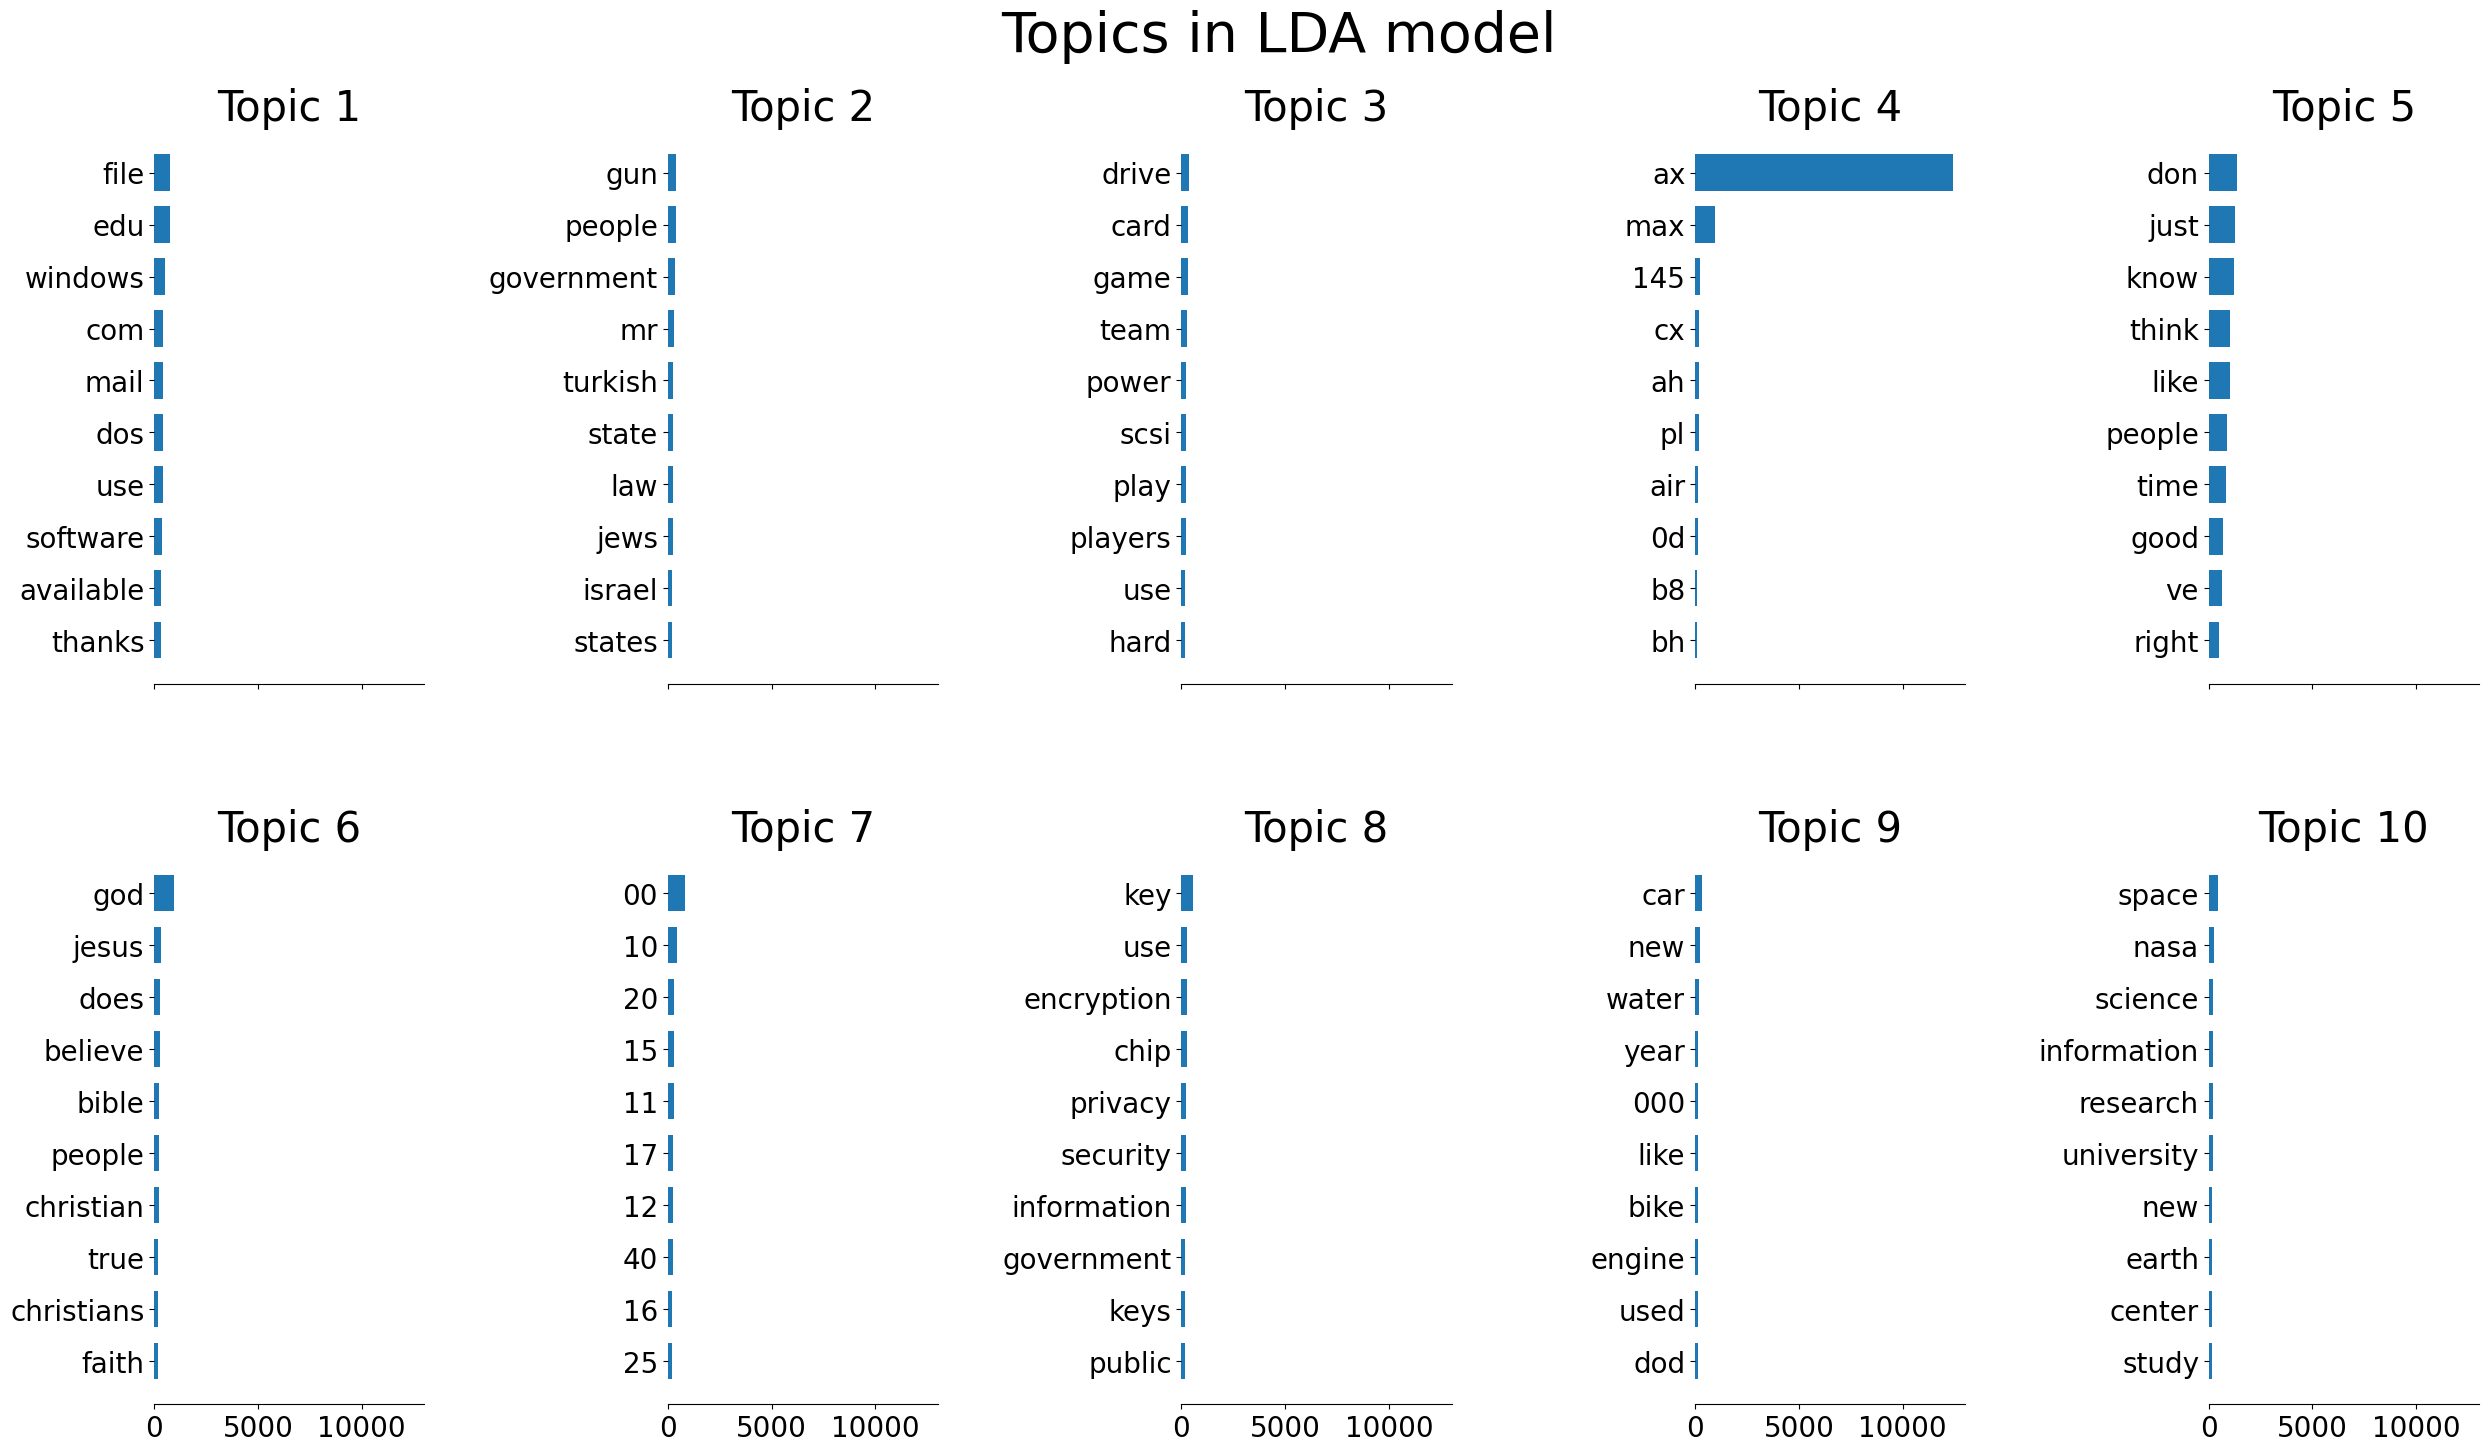

In [101]:
plot_top_words(lda, tf_vectorizer.get_feature_names_out(), 10, "Topics in LDA model")